# Setup

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import agate
import warnings
import requests
import zipfile
import io
import json

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import locale
import arrow
import xml.etree.ElementTree as ET

from locale import atof
from dateutil import parser
from datetime import datetime

plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 10

warnings.filterwarnings('ignore')


/Users/deads/.virtualenvs/trump-tweet-analysis/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/deads/.virtualenvs/trump-tweet-analysis/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/deads/.virtualenvs/trump-tweet-analysis/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/deads/.virtualenvs/trump-tweet-analysis/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/deads/.virtualenvs/trump-tweet-analysis/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/deads/.virtualenvs/trump-tweet-analysis/lib/pyth

# Trump Tweet analysis

A look at Trump's tweets since inauguration day.

## Questions to answer

### Data processing

* Date grouping columns
* Sentiment analysis

### Analysis

* Frequencies sliced several ways: By day, month, hour of day
* Rates: Tweets/day, Tweets/day/month
* Retweets: What was shared heavily?
* Searches: 
  * Media organizations

# Get data

_Only run this if you need to update the Trump tweet data, for example the first time you run this script._

First, download the zipfile and unzip it in `data` directory.

**@TODO**: Cache zip files locally, read from zip into ignored local file.

In [2]:
response = requests.get('https://github.com/bpb27/trump_tweet_data_archive/raw/master/master_2017.json.zip')
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall('data')

Open the downloaded, unzipped JSON file, run sentiment analysis, remove multi-valued `entities` field, and create `data/master_2017_processed.json`.

In [3]:
with open('data/master_2017.json') as f:
    jsondata = json.load(f)

analyzer = SentimentIntensityAnalyzer()
for row in jsondata:
    del(row['entities'])
    vs = analyzer.polarity_scores(row['text'])
    row['sentiment'] = vs

with open('data/master_2017_processed.json', 'w') as f:
    json.dump(jsondata, f)

# Utilities

_Add helper functions here._

In [4]:
# Stub for helpers
# convert utc to est
def convertUTCtoFull(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('dddd, MMM D, YYYY h:mm A')

# convert to month
def convertUTCtoMonth(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('MM')

# convert to day
def convertUTCtoDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('D')

# convert to month/day
def convertUTCtoMonthDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY-MM-DD')

# convert to day of week
def convertUTCtoDayOfWeek(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('d')

# convert to time
def convertUTCtoHourOfDay(date):
    utc = arrow.get(date)
    return int(utc.to('US/Eastern').format('HH'))

# convert to week of year
def convertUTCtoWeekNumber(date):
    return int(date.strftime('%U'))

# Strip HTML
def stripHTML(html):
    tree = ET.fromstring(html)
    return ET.tostring(tree, encoding='utf8', method='text')

# Data processing

Open the `json` file and then use the `json_normalize()` function to flatten it for use with Pandas, which doesn't like nested json.

In [5]:
with open('data/master_2017_processed.json') as f:
    jsondata = json.load(f)
normalized_json = pd.io.json.json_normalize(jsondata)
tweets = pd.DataFrame(normalized_json)
tweets['created_date'] = pd.to_datetime(tweets['created_at'])

Add many time grouping columns.

In [6]:
tweets['human_date'] = tweets['created_date'].apply(convertUTCtoFull)
tweets['month/day'] = tweets['created_date'].apply(convertUTCtoMonthDay)
tweets['month'] = tweets['created_date'].apply(convertUTCtoMonth)
tweets['day'] = tweets['created_date'].apply(convertUTCtoDay)
tweets['day of week'] = tweets['created_date'].apply(convertUTCtoDayOfWeek)
tweets['hour'] = tweets['created_date'].apply(convertUTCtoHourOfDay)
tweets['week'] = tweets['created_date'].apply(convertUTCtoWeekNumber)
tweets.set_index('created_date', inplace=True)

# Sources

In [7]:
tweets['source_clean'] = tweets['source'].apply(stripHTML)
tweets['source_clean'].unique()

array([b'Twitter for iPhone', b'Twitter Ads', b'Media Studio',
       b'Twitter for Android', b'Twitter Web Client'], dtype=object)

# Frequencies

## Total Tweets

In [8]:
len(tweets.index)

631

## Tweets per hour

Trump loves the morning hours, especially the 8am-9am range.

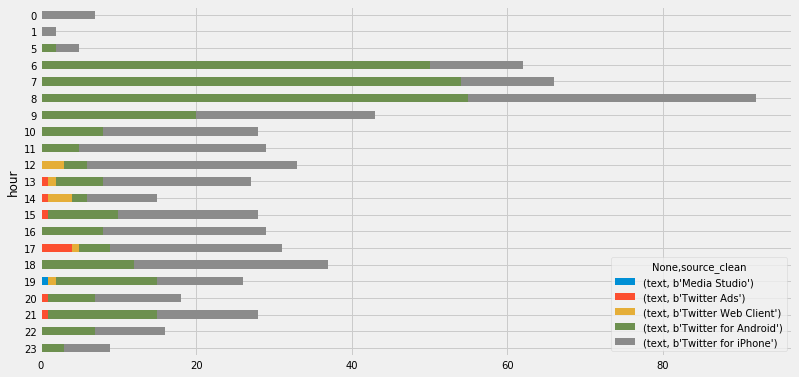

In [9]:
tweetsPerHour = tweets[['source_clean', 'hour', 'text']].pivot_table(
    index='hour', columns=['source_clean'], aggfunc='count')
tweetsPerHour.to_csv('output/tweets-per-hour-of-day.csv')
tweetsPerHour.iloc[::-1].plot(kind='barh', stacked=True)

## Tweets per day

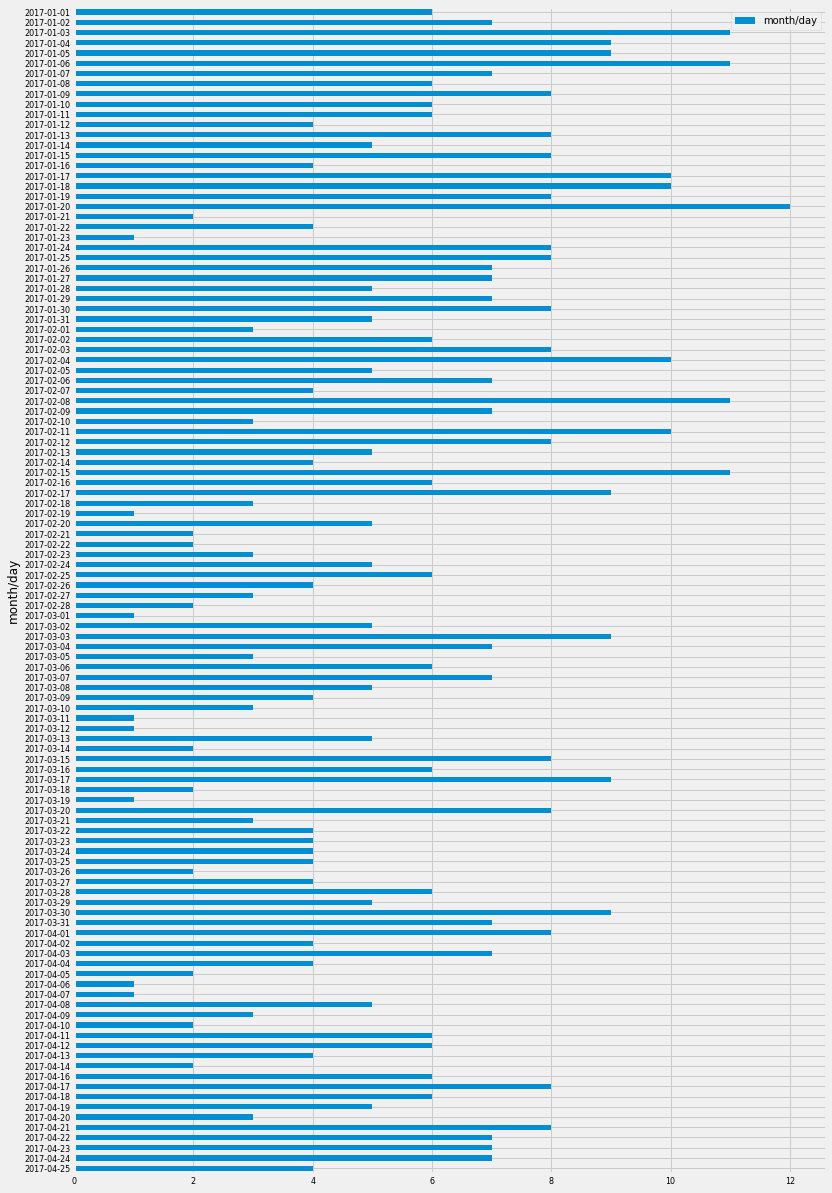

In [10]:
tweetsPerDay = tweets[['month/day']].groupby(tweets['month/day']).count()
tweetsPerDay.iloc[::-1].plot(kind='barh', figsize=(12,20), fontsize=8)

In [11]:
tweetsPerDay.describe()

,month/day
count,114.000000
mean,5.535088
std,2.704241
min,1.000000
25%,4.000000
50%,5.500000
75%,7.750000
max,12.000000


## Tweets per day of week

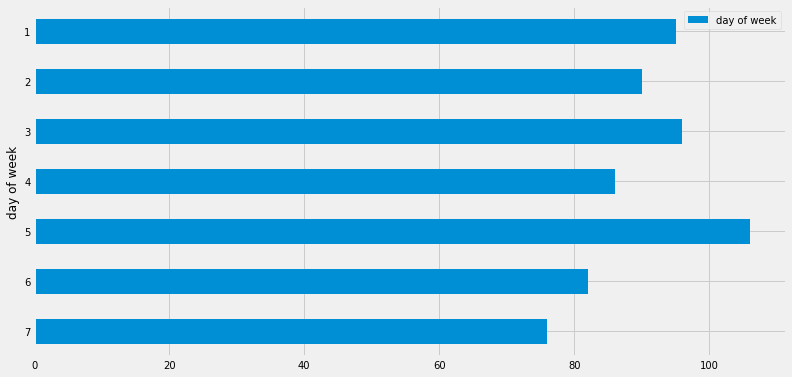

In [12]:
tweetsPerDayOfWeek = tweets[['day of week']].groupby(tweets['day of week']).count()
tweetsPerDayOfWeek.iloc[::-1].plot(kind='barh')

## Tweets per month

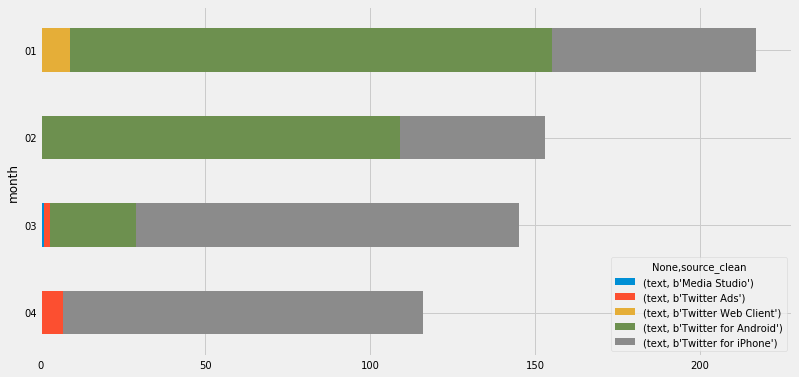

In [13]:
tweetsPerMonth = tweets[['source_clean', 'month', 'text']].pivot_table(index='month', columns=['source_clean'], aggfunc='count')
tweetsPerMonth.iloc[::-1].plot(kind='barh', stacked=True)

## Tweets per week

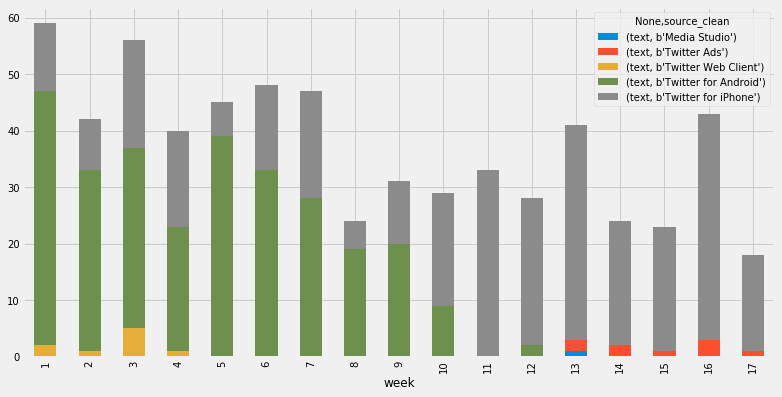

In [14]:
tweetsPerWeek = tweets[['source_clean', 'week', 'text']].pivot_table(index='week', columns=['source_clean'], aggfunc='count')
tweetsPerWeek.to_csv('output/tweetsperweek-by-device.csv', na_rep=0)
tweetsPerWeek.plot(kind='bar', stacked=True)

# Sentiment

We see a significant increase in Trump's "positivity" as measured by VADER (the same algorithm that is used by BOTUS).

_Jupyter is both amazin and stupid... this disabled scrolling to let me loop over plotting._


In [15]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## By month

In [16]:
sentiment_fields = ['sentiment.compound'] #, 'sentiment.pos', 'sentiment.neg', 'sentiment.neu']

### Average

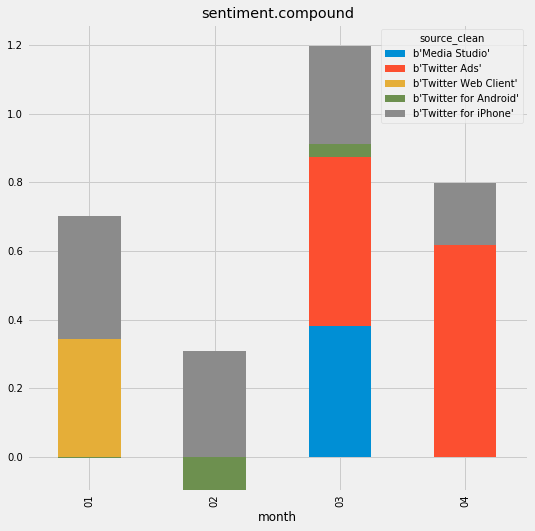

In [17]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'month', field]].pivot_table(index='month', columns='source_clean', values=field, aggfunc='mean')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

### Cumulative

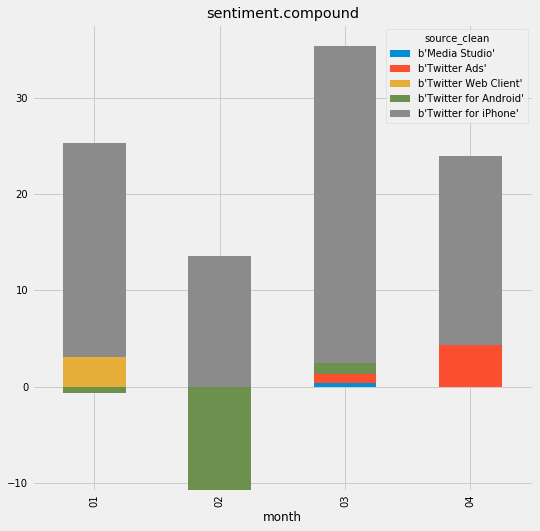

In [18]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'month', field]].pivot_table(index='month', columns='source_clean', values=field, aggfunc='sum')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

## By week

### Average

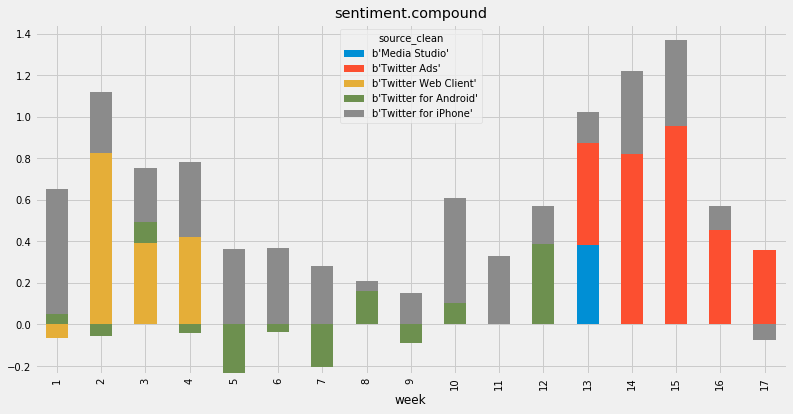

In [19]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'week', field]].pivot_table(index='week', columns='source_clean', values=field, aggfunc='mean')
    sentimentByMonth.to_csv('output/sentiment-by-week.csv')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Cumulative

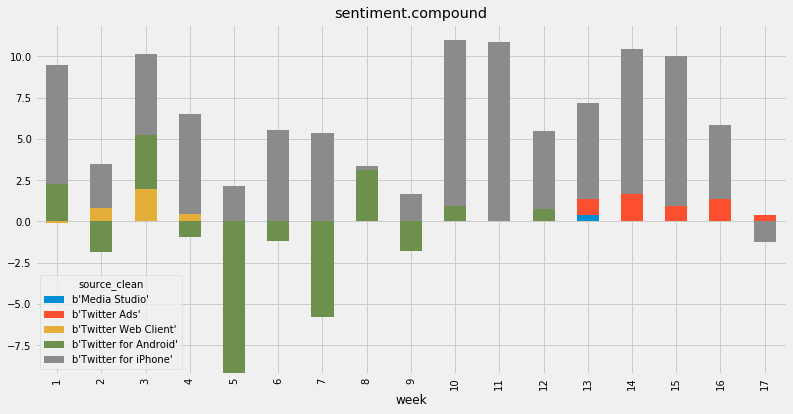

In [20]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'week', field]].pivot_table(index='week', columns='source_clean', values=field, aggfunc='sum')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Average, not broken down by device

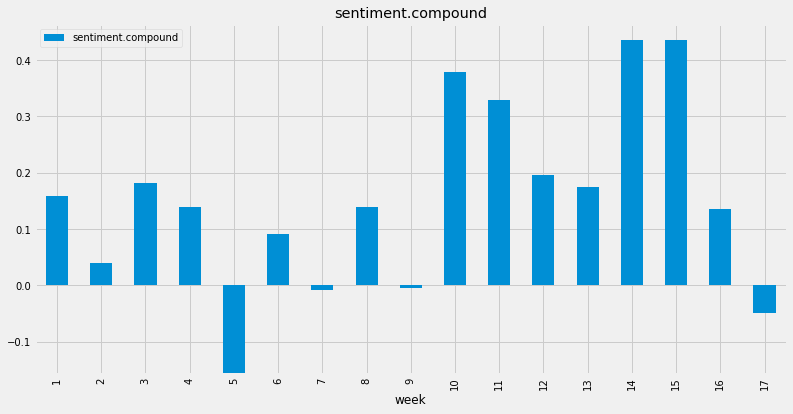

In [ ]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['week', field]].groupby('week').mean()
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

## Every Tweet's sentiment analysis

In [ ]:
tweets['sentiment.compound'].plot(kind='bar', ylim=[-1,1], figsize=(90,12))

# Follower count

The strange drops in follower count are interesting here. The follower ceiling is strangely lacking in noise.

In [ ]:
tweets['user.followers_count'].plot()

In [ ]:
tweets['user.followers_count'].resample('W').plot()

# Text analysis

Common words.

In [ ]:
from collections import Counter
import nltk
import string
nltk.download('stopwords')

In [ ]:
top_N = 100
stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + ['rt']
# RegEx for stopwords
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
words = (tweets.text
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DF out of Counter
words_data = pd.DataFrame(Counter(words).most_common(300),
                    columns=['Word', 'Frequency']).set_index('Word')

pd.set_option('display.max_rows', top_N)
words_data.to_csv('output/word-frequencies.csv')
words_data.head(top_N)
#pd.reset_option('display.max_rows')

# plot
# rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

# Specific text searches

In [ ]:
from IPython.display import display, Markdown
def analyzeText(search):
    display(Markdown('## Search: _{0}_'.format(search)))
    filtered = tweets[tweets['text'].str.contains(search, case=False)]
    count = len(filtered)
    percent = float(len(filtered))/len(tweets) * 100
    display(Markdown('Number of Tweets: {0}'.format(count)))
    display(Markdown('Percent of all Tweets: {0:.2f}%'.format(percent)))
    analyzedByWeek = filtered[['source_clean', 'week', 'text']].pivot_table(index='week', columns='source_clean', aggfunc='count')
    analyzedByWeek = analyzedByWeek.reindex(range(tweets['week'].min(), tweets['week'].max())).fillna(0)
    analyzedByWeek.to_csv('output/word-by-week-{0}.csv'.format(search))
    analyzedByWeekPlot = analyzedByWeek.plot(kind='bar', stacked=True, title='{0} by week'.format(search)) 
    plt.show()
    analyzedByHour = filtered[['source_clean', 'hour', 'text']].pivot_table(index='hour', columns='source_clean', aggfunc='count')
    analyzedByHour = analyzedByHour.reindex(range(0, 24)).fillna(0)
    analyzedByHour.to_csv('output/word-by-hour-{0}.csv'.format(search))
    analyzedByHourPlot = analyzedByHour.plot(kind='bar', stacked=True, title='{0} by hour of day'.format(search))
    plt.show()
    display(Markdown('### The Tweets'))
    for i, row in filtered.iterrows():
        display(Markdown('[{0}](https://twitter.com/realDonaldTrump/status/{2}): {1}'.format(row['human_date'], row['text'], row['id'])))
    display(Markdown('---'))

In [ ]:
searches = ['great', 'fake', 'mexic', 'fox', 'terror', 'ivanka', 'ms 13', 'russia', 'failing', 'election']
for search in searches:
    analyzeText(search)